In [16]:
import json
import collections
import numpy as np 
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.utils.convert import to_networkx
from torch_geometric.nn import GCNConv
from torch_geometric.transforms import RandomNodeSplit as masking

import networkx as nx 
#matplotlib inline

In [2]:
data_dir = "/home/jjia/data/dataset/pointnet/git_web_ml/"
with open(data_dir + "musae_git_features.json") as json_data:
    data_raw = json.load(json_data)
edges=pd.read_csv(data_dir + "musae_git_edges.csv")
target_df=pd.read_csv(data_dir + "musae_git_target.csv")
print("5 top nodes labels")
print(target_df.head(5).to_markdown())
print()
print("5 last nodes")
print(target_df.tail(5).to_markdown())

5 top nodes labels
|    |   id | name         |   ml_target |
|---:|-----:|:-------------|------------:|
|  0 |    0 | Eiryyy       |           0 |
|  1 |    1 | shawflying   |           0 |
|  2 |    2 | JpMCarrilho  |           1 |
|  3 |    3 | SuhwanCha    |           0 |
|  4 |    4 | sunilangadi2 |           1 |

5 last nodes
|       |    id | name           |   ml_target |
|------:|------:|:---------------|------------:|
| 37695 | 37695 | shawnwanderson |           1 |
| 37696 | 37696 | kris-ipeh      |           0 |
| 37697 | 37697 | qpautrat       |           0 |
| 37698 | 37698 | Injabie3       |           1 |
| 37699 | 37699 | caseycavanagh  |           0 |


In [3]:
feat_counts = [len(data_raw[key]) for key in data_raw.keys()]

In [21]:
data_raw.keys()

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', 

In [4]:
feats = []
tmp = [feats.extend(data_raw[key]) for key in data_raw.keys()]

In [5]:
len(feats)

690374

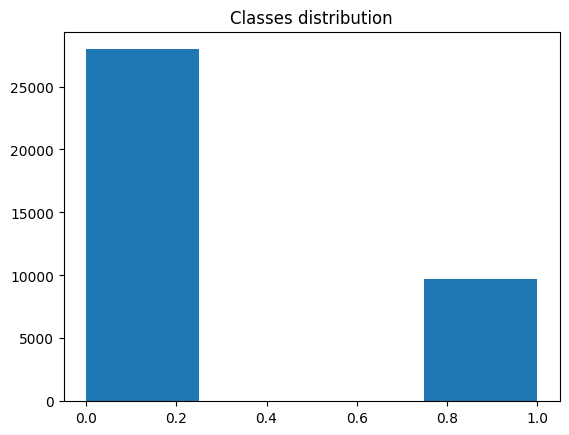

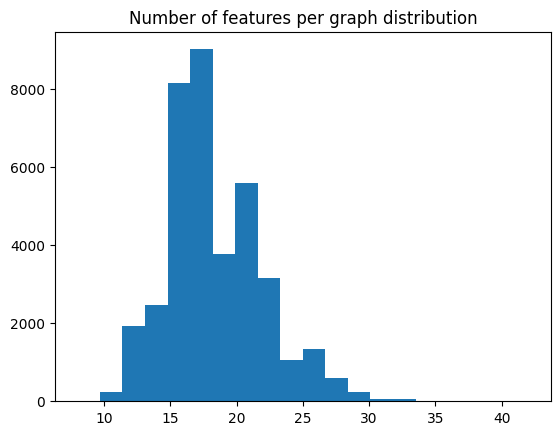

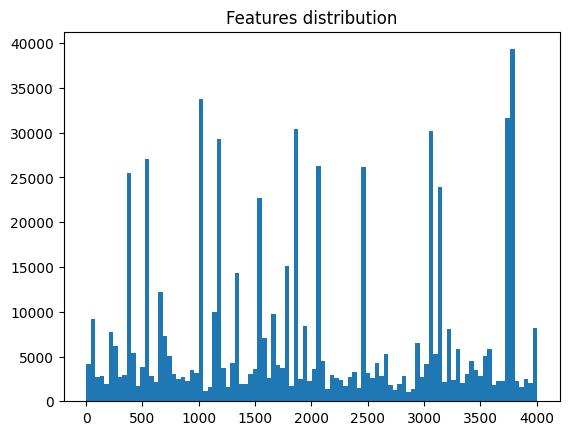

In [6]:
plt.hist(target_df.ml_target,bins=4);
plt.title("Classes distribution")
plt.show()
plt.hist(feat_counts,bins=20)
plt.title("Number of features per graph distribution")
plt.show()
plt.hist(feats,bins=100)
plt.title("Features distribution")
plt.show()

In [7]:
def encode_data(light=False,n=60):
    if light==True:
        nodes_included=n
    elif light==False:
        nodes_included=len(data_raw)
    data_encoded={}
    for i in range(nodes_included):# 
        one_hot_feat=np.array([0]*(max(feats)+1))
        this_feat=data_raw[str(i)]
        one_hot_feat[this_feat]=1
        data_encoded[str(i)]=list(one_hot_feat)
    if light==True:
        sparse_feat_matrix=np.zeros((1,max(feats)+1))
        for j in range(nodes_included):
            temp=np.array(data_encoded[str(j)]).reshape(1,-1)
            sparse_feat_matrix=np.concatenate((sparse_feat_matrix,temp),axis=0)
        sparse_feat_matrix=sparse_feat_matrix[1:,:]
        return(data_encoded,sparse_feat_matrix)
    elif light==False:
        return(data_encoded, None)

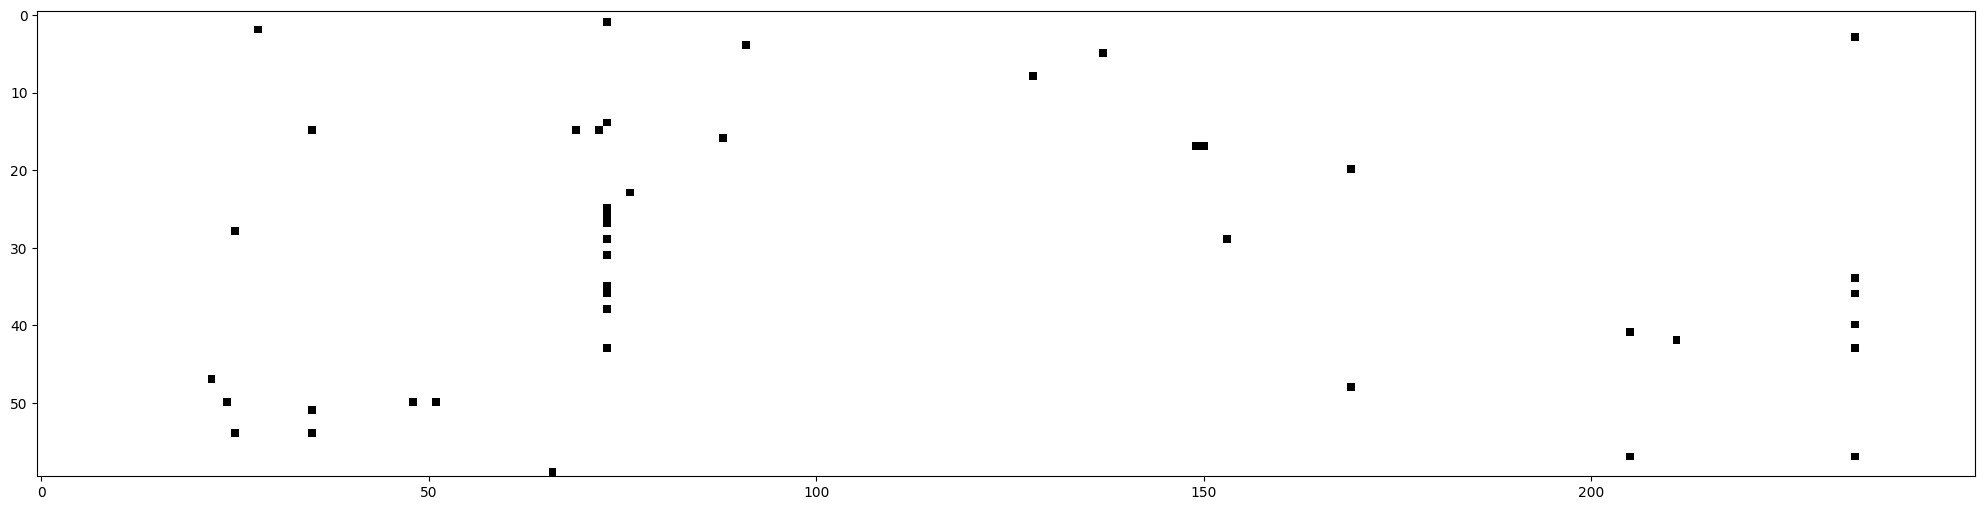

In [8]:
data_encoded_vis,sparse_feat_matrix_vis=encode_data(light=True,n=60)
plt.figure(figsize=(25,25));
plt.imshow(sparse_feat_matrix_vis[:,:250],cmap='Greys');

In [9]:
def construct_graph(data_encoded,light=False):
    node_features_list=list(data_encoded.values())
    node_features=torch.tensor(node_features_list)
    node_labels=torch.tensor(target_df['ml_target'].values)
    edges_list=edges.values.tolist()
    edge_index01=torch.tensor(edges_list, dtype = torch.long).T
    edge_index02=torch.zeros(edge_index01.shape, dtype = torch.long)#.T
    edge_index02[0,:]=edge_index01[1,:]
    edge_index02[1,:]=edge_index01[0,:]
    edge_index0=torch.cat((edge_index01,edge_index02),axis=1)
    g = Data(x=node_features, y=node_labels, edge_index=edge_index0)
    g_light = Data(x=node_features[:,0:2],
                     y=node_labels   ,
                     edge_index=edge_index0[:,:55])
    if light:
        return(g_light)
    else:
        return(g)

In [10]:
def draw_graph(data0):
    #node_labels=data0.y
    if data0.num_nodes>100:
        print("This is a big graph, can not plot...")
        return
    else:
        data_nx = to_networkx(data0)
        node_colors=data0.y[list(data_nx.nodes)]
        pos= nx.spring_layout(data_nx,scale =1)
        plt.figure(figsize=(12,8))
        nx.draw(data_nx, pos,  cmap=plt.get_cmap('Set1'),
                node_color =node_colors,node_size=600,connectionstyle="angle3",
                width =1, with_labels = False, edge_color = 'k', arrowstyle = "-")

In [11]:
g_sample=construct_graph(data_encoded=data_encoded_vis,light=True)


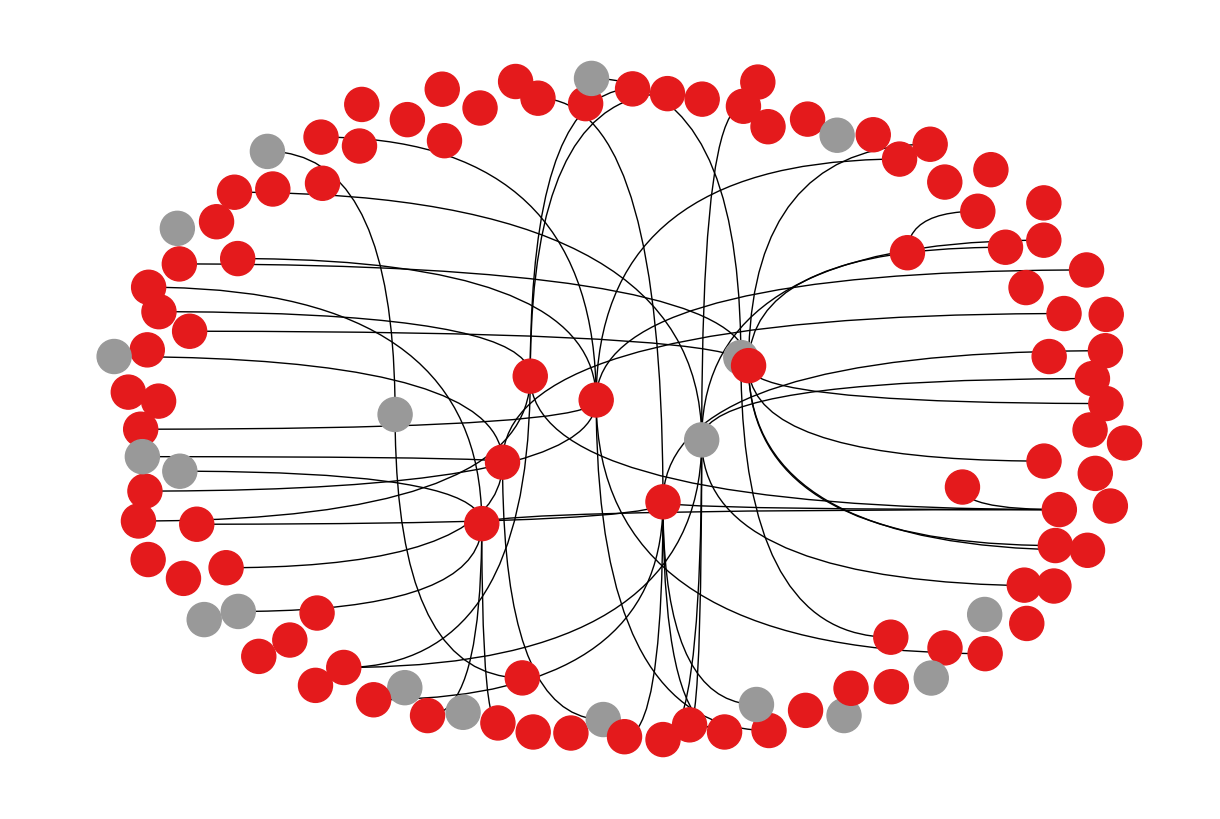

In [12]:
draw_graph(g_sample)

In [13]:
data_encoded,_=encode_data(light=False)
g=construct_graph(data_encoded=data_encoded,light=False)

In [17]:
msk=masking(split="train_rest", num_splits = 1, num_val = 0.3, num_test= 0.6)
g=msk(g)
print(g)
print()
print("training samples",torch.sum(g.train_mask).item())
print("validation samples",torch.sum(g.val_mask ).item())
print("test samples",torch.sum(g.test_mask ).item())

Data(x=[37700, 4005], edge_index=[2, 578006], y=[37700], train_mask=[37700], val_mask=[37700], test_mask=[37700])

training samples 3770
validation samples 11310
test samples 22620


In [18]:
class SocialGNN(torch.nn.Module):
    def __init__(self,num_of_feat,f):
        super(SocialGNN, self).__init__()
        self.conv1 = GCNConv(num_of_feat, f)
        self.conv2 = GCNConv(f, 2)
    def forward(self, data):
        x = data.x.float()
        edge_index =  data.edge_index
        x = self.conv1(x=x, edge_index=edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [19]:
def masked_loss(predictions,labels,mask):
    mask=mask.float()
    mask=mask/torch.mean(mask)
    loss=criterion(predictions,labels)
    loss=loss*mask
    loss=torch.mean(loss)
    return (loss)    
def masked_accuracy(predictions,labels,mask):
    mask=mask.float()
    mask/=torch.mean(mask)
    accuracy=(torch.argmax(predictions,axis=1)==labels).long()
    accuracy=mask*accuracy
    accuracy=torch.mean(accuracy)
    return (accuracy)

In [20]:
def train_social(net,data,epochs=10,lr=0.01):
    optimizer = torch.optim.Adam(net.parameters(), lr=lr) # 00001
    best_accuracy=0.0
    train_losses=[]
    train_accuracies=[]
    val_losses=[]
    val_accuracies=[]
    test_losses=[]
    test_accuracies=[]
    for ep in range(epochs+1):
        optimizer.zero_grad()
        out=net(data)
        loss=masked_loss(predictions=out,
                         labels=data.y,
                         mask=data.train_mask)
        loss.backward()
        optimizer.step()
        train_losses+=[loss]
        train_accuracy=masked_accuracy(predictions=out,
                                       labels=data.y, 
                                       mask=data.train_mask)
        train_accuracies+=[train_accuracy]
        val_loss=masked_loss(predictions=out,
                             labels=data.y, 
                             mask=data.val_mask)
        val_losses+=[val_loss]
        val_accuracy=masked_accuracy(predictions=out,
                                     labels=data.y, 
                                     mask=data.val_mask)
        val_accuracies+=[val_accuracy]
        test_accuracy=masked_accuracy(predictions=out,
                                      labels=data.y, 
                                      mask=data.test_mask)
        test_accuracies+=[test_accuracy]
        if np.round(val_accuracy,4)> np.round(best_accuracy ,4):
            print("Epoch {}/{}, Train_Loss: {:.4f}, Train_Accuracy: {:.4f}, Val_Accuracy: {:.4f}, Test_Accuracy: {:.4f}"
                      .format(ep+1,epochs, loss.item(), train_accuracy, val_accuracy,  test_accuracy))
            best_accuracy=val_accuracy
    plt.plot(train_losses)  
    plt.plot(val_losses)
    plt.plot(test_losses)  
    plt.show()
    plt.plot(train_accuracies) 
    plt.plot(val_accuracies)
    plt.plot(test_accuracies) 
    plt.show()

Epoch 1/50, Train_Loss: 0.6710, Train_Accuracy: 0.7477, Val_Accuracy: 0.7356, Test_Accuracy: 0.7434
Epoch 3/50, Train_Loss: 0.5595, Train_Accuracy: 0.7493, Val_Accuracy: 0.7358, Test_Accuracy: 0.7437
Epoch 4/50, Train_Loss: 0.4717, Train_Accuracy: 0.7897, Val_Accuracy: 0.7760, Test_Accuracy: 0.7793
Epoch 5/50, Train_Loss: 0.5139, Train_Accuracy: 0.8599, Val_Accuracy: 0.8602, Test_Accuracy: 0.8621
Epoch 7/50, Train_Loss: 0.4491, Train_Accuracy: 0.8586, Val_Accuracy: 0.8660, Test_Accuracy: 0.8667
Epoch 14/50, Train_Loss: 0.3835, Train_Accuracy: 0.8613, Val_Accuracy: 0.8673, Test_Accuracy: 0.8682
Epoch 15/50, Train_Loss: 0.3844, Train_Accuracy: 0.8629, Val_Accuracy: 0.8677, Test_Accuracy: 0.8680
Epoch 16/50, Train_Loss: 0.3745, Train_Accuracy: 0.8645, Val_Accuracy: 0.8689, Test_Accuracy: 0.8690
Epoch 17/50, Train_Loss: 0.3590, Train_Accuracy: 0.8639, Val_Accuracy: 0.8698, Test_Accuracy: 0.8703
Epoch 23/50, Train_Loss: 0.3360, Train_Accuracy: 0.8703, Val_Accuracy: 0.8699, Test_Accuracy: 0.

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

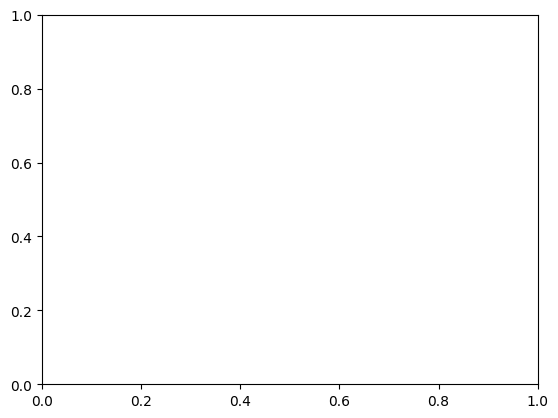

In [22]:
num_of_feat=g.num_node_features
net=SocialGNN(num_of_feat=num_of_feat,f=16)
criterion=torch.nn.CrossEntropyLoss()
train_social(net,g,epochs=50,lr=0.1)

In [23]:
#install required packages
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt

2.0.1+cu117


In [24]:
def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()

In [25]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()

In [26]:
print('Dataset properties')
print('==============================================================')
print(f'Dataset: {dataset}') #This prints the name of the dataset
print(f'Number of graphs in the dataset: {len(dataset)}')
print(f'Number of features: {dataset.num_features}') #Number of features each node in the dataset has
print(f'Number of classes: {dataset.num_classes}') #Number of classes that a node can be classified into


#Since we have one graph in the dataset, we will select the graph and explore it's properties

data = dataset[0]
print('Graph properties')
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}') #Number of nodes in the graph
print(f'Number of edges: {data.num_edges}') #Number of edges in the graph
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}') # Average number of nodes in the graph
print(f'Contains isolated nodes: {data.has_isolated_nodes()}') #Does the graph contains nodes that are not connected
print(f'Contains self-loops: {data.has_self_loops()}') #Does the graph contains nodes that are linked to themselves
print(f'Is undirected: {data.is_undirected()}') #Is the graph an undirected graph

Dataset properties
Dataset: KarateClub()
Number of graphs in the dataset: 1
Number of features: 34
Number of classes: 4
Graph properties
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


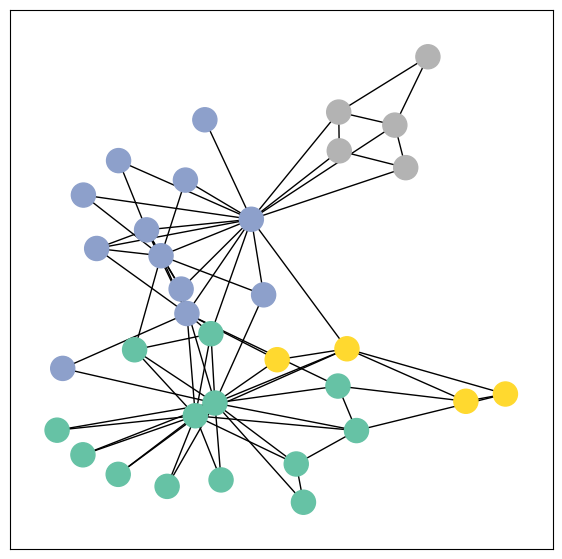

In [27]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

In [28]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.
        
        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


In [29]:
model = GCN()
criterion = torch.nn.CrossEntropyLoss()  #Initialize the CrossEntropyLoss function.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Initialize the Adam optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h

for epoch in range(401):
    loss, h = train(data)
    print(f'Epoch: {epoch}, Loss: {loss}')

Epoch: 0, Loss: 1.414404273033142
Epoch: 1, Loss: 1.4079036712646484
Epoch: 2, Loss: 1.4017865657806396
Epoch: 3, Loss: 1.3959276676177979
Epoch: 4, Loss: 1.3902204036712646
Epoch: 5, Loss: 1.3845514059066772
Epoch: 6, Loss: 1.3788156509399414
Epoch: 7, Loss: 1.372924566268921
Epoch: 8, Loss: 1.3668041229248047
Epoch: 9, Loss: 1.3603922128677368
Epoch: 10, Loss: 1.3536320924758911
Epoch: 11, Loss: 1.346463680267334
Epoch: 12, Loss: 1.3388220071792603
Epoch: 13, Loss: 1.330651879310608
Epoch: 14, Loss: 1.321907877922058
Epoch: 15, Loss: 1.312545895576477
Epoch: 16, Loss: 1.3025131225585938
Epoch: 17, Loss: 1.2917399406433105
Epoch: 18, Loss: 1.2801498174667358
Epoch: 19, Loss: 1.267681360244751
Epoch: 20, Loss: 1.2542929649353027
Epoch: 21, Loss: 1.2399559020996094
Epoch: 22, Loss: 1.224645733833313
Epoch: 23, Loss: 1.208348035812378
Epoch: 24, Loss: 1.1910830736160278
Epoch: 25, Loss: 1.172907829284668
Epoch: 26, Loss: 1.1538856029510498
Epoch: 27, Loss: 1.1340938806533813
Epoch: 28, L